#📌 Importar dados

In [376]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import sklearn.metrics as metrics
import sklearn.preprocessing as preprocessing
import sklearn.model_selection as model_selection
import sklearn.tree as tree
import sklearn.metrics as metrics
import sklearn.pipeline as pipeline
import sklearn.neighbors as neighbors
import imblearn.under_sampling as under
import imblearn.under_sampling as under
import imblearn.pipeline as imbpipeline
import imblearn.over_sampling as over
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler


#📌 Conhecendo dados

In [377]:
#Lendo dados

dados = pd.read_json('/content/dados.json', lines=True)
dados.head(5)

,ID Cliente,Evasao,Genero,idoso,Parceiro,Dependentes,Meses como cliente,Telefone fixo,Múltiplas linhas,Serviço de internet,...,Contrato,Fatura online,Metodo de pagamento,Fatura mensal,Fatura Total,Dias como cliente,Valor Diario,Evasao_num,Faixa_tempo_cliente,faixa_gasto
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,One year,Yes,Mailed check,65.6,593.30,270,2.20,0.0,0-12,501-1000
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,Month-to-month,No,Mailed check,59.9,542.40,270,2.01,0.0,0-12,501-1000
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,Month-to-month,Yes,Electronic check,73.9,280.85,120,2.34,1.0,0-12,0-500
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Month-to-month,Yes,Electronic check,98.0,1237.85,390,3.17,1.0,13-24,1001-1500
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,Month-to-month,Yes,Mailed check,83.9,267.40,90,2.97,1.0,0-12,0-500


In [378]:
#Conhecendo colunas

dados.columns

Index(['ID Cliente', 'Evasao', 'Genero', 'idoso', 'Parceiro', 'Dependentes',
       'Meses como cliente', 'Telefone fixo', 'Múltiplas linhas',
       'Serviço de internet', 'Seguranca online', 'Backup',
       'Protecao de dispositivo', 'Suporte tecnico', 'Streaming TV',
       'Streaming filmes', 'Contrato', 'Fatura online', 'Metodo de pagamento',
       'Fatura mensal', 'Fatura Total', 'Dias como cliente', 'Valor Diario',
       'Evasao_num', 'Faixa_tempo_cliente', 'faixa_gasto'],
      dtype='object')

In [379]:
#Limpando o DataFrame

dados = dados.drop(columns=['ID Cliente','Evasao_num',
 'Dias como cliente', 'Valor Diario'])

In [380]:
dados['Evasao'].value_counts()

,count
Evasao,
No,5174
Yes,1869
,224


In [381]:
#Copiar DataFrame original

dados = dados.copy()

In [382]:
#Tratar casos específicos ("No internet service" → "No")

cols_to_fix = [
    'Serviço de internet', 'Seguranca online', 'Backup',
    'Protecao de dispositivo', 'Suporte tecnico', 'Streaming TV',
    'Streaming filmes','Múltiplas linhas'
]
for col in cols_to_fix:
    dados[col] = dados[col].replace('No internet service', 'No')

In [383]:
# Mapear colunas categóricas em dummies (numéricas)
cols_to_map = ['Genero', 'Parceiro', 'Dependentes']
for col in cols_to_map:
    dados[col] = dados[col].replace({'Yes': True, 'No': False})

/tmp/ipython-input-2334547849.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dados[col] = dados[col].replace({'Yes': True, 'No': False})


In [384]:
# Transformar colunas categóricas em variáveis dummy
dados= pd.get_dummies(dados, columns=['Contrato', 'Metodo de pagamento'])

In [385]:
dados['Evasao'].value_counts()

,count
Evasao,
No,5174
Yes,1869
,224


In [386]:
# Mantém apenas linhas onde 'Evasao' não é vazio
dados = dados[dados['Evasao'] != '']

In [387]:
# 'Yes' → 1 (inadimplente / evadiu), 'No' → 0 (adimplente / não evadiu)

dados['Evasao'] = dados['Evasao'].replace({'No': 0, 'Yes': 1})

/tmp/ipython-input-591267513.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dados['Evasao'] = dados['Evasao'].replace({'No': 0, 'Yes': 1})


In [388]:
dados[['Genero', 'Parceiro', 'Dependentes']] = dados[['Genero', 'Parceiro', 'Dependentes']].replace({
    'female': 0, 'male': 1,
    'No': 0, 'Yes': 1,
    'Não': 0, 'Sim': 1
})

In [389]:
dados['Faixa_tempo_cliente'].value_counts()

,count
Faixa_tempo_cliente,
0-12,2069
61-72,1121
13-24,1047
25-36,876
49-60,820
37-48,748


In [390]:
# # Exemplo: "13-24" → 18.5
# dados['Faixa_tempo_cliente_float'] = (
#     dados['Faixa_tempo_cliente']
#     .astype(str)
#     .str.extract(r'(\d+)-(\d+)')        # captura início e fim
#     .astype(float)                      # converte para float
#     .mean(axis=1)                       # pega a média
# )


#📌Análise de Direcionda

##📊 Evasão por tempo de contrato

In [391]:
# Criar um mapeamento faixa -> média
mapa_faixa = {
    '0-12': 6.0,
    '13-24': 18.5,
    '25-36': 30.5,
    '37-48': 42.5,
    '49-60': 54.5,
    '61-72': 66.5
}

# Aplicar ao DataFrame
dados['Faixa_tempo_cliente'] = dados['Faixa_tempo_cliente'].map(mapa_faixa)


/tmp/ipython-input-3960249374.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


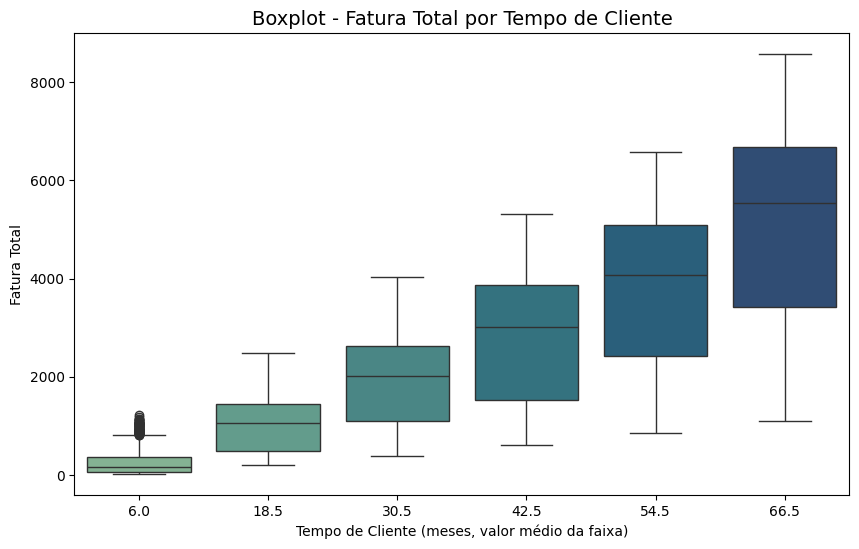

In [392]:
plt.figure(figsize=(10,6))
sns.boxplot(
    data=dados,
    x='Faixa_tempo_cliente',
    y='Fatura Total',
    palette='crest'
)

plt.title('Boxplot - Fatura Total por Tempo de Cliente', fontsize=14)
plt.xlabel('Tempo de Cliente (meses, valor médio da faixa)')
plt.ylabel('Fatura Total')
plt.show()

##📊 Evasão por Gasto total

/tmp/ipython-input-1491096104.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


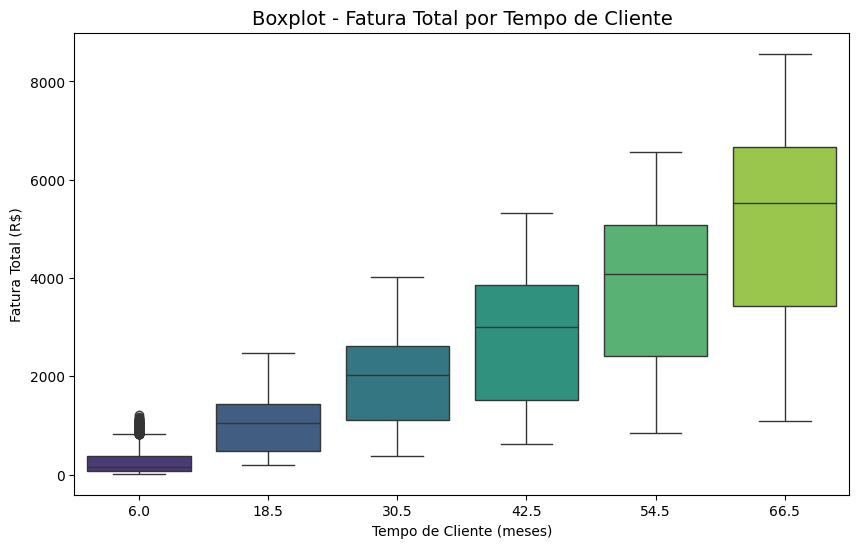

In [394]:
# Certifique-se de que 'Fatura Total' e 'Evasao' são numéricos
dados['Fatura Total'] = pd.to_numeric(dados['Fatura Total'], errors='coerce')
dados['Evasao'] = pd.to_numeric(dados['Evasao'], errors='coerce')

# Criar faixas de gasto
bins = [0, 500, 1000, 1500, 2000, dados['Fatura Total'].max()]
labels = ['0-500', '501-1000', '1001-1500', '1501-2000', '2000+']
dados['faixa_gasto'] = pd.cut(dados['Fatura Total'], bins=bins, labels=labels, right=False)

# Remover linhas com NaN em 'Evasao' ou 'faixa_gasto'
dados.dropna(subset=['Evasao', 'faixa_gasto'], inplace=True)

#Gráfico
plt.figure(figsize=(10,6))
sns.boxplot(
    data=dados,
    x='Faixa_tempo_cliente',
    y='Fatura Total',
    palette='viridis'
)

plt.title('Boxplot - Fatura Total por Tempo de Cliente', fontsize=14)
plt.xlabel('Tempo de Cliente (meses)')
plt.ylabel('Fatura Total (R$)')
plt.show()

#📌 Análise de correlação entre diferentes variáveis

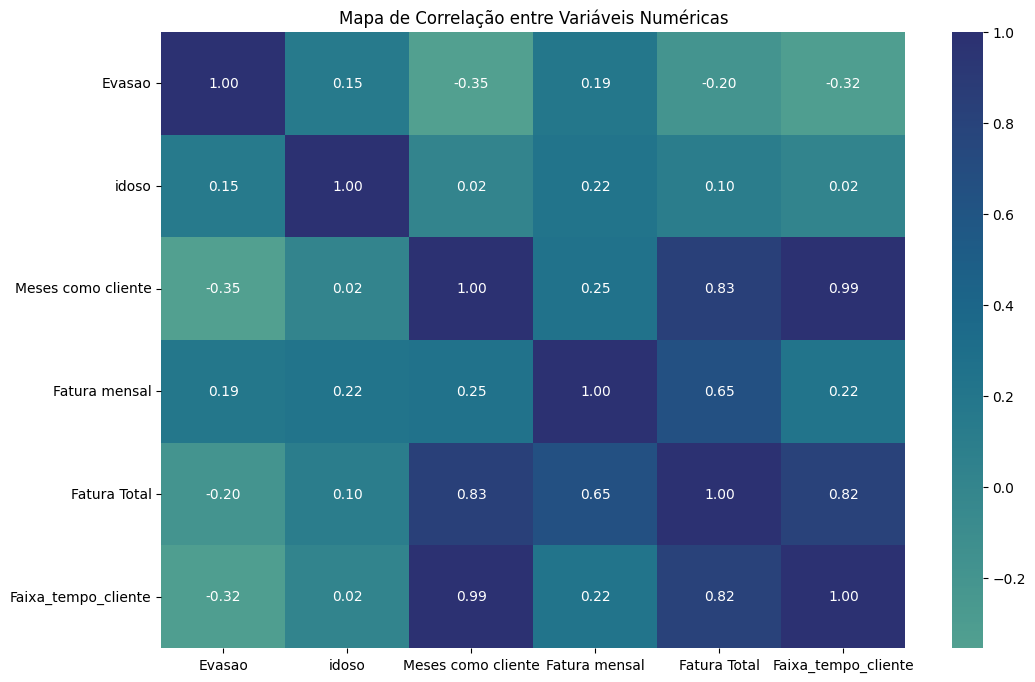

In [395]:
corr_matrix = dados.select_dtypes(include=np.number).corr()

# Plotar heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt ='.2f', cmap = 'crest', center = 0)
plt.title('Mapa de Correlação entre Variáveis Numéricas')
plt.show()

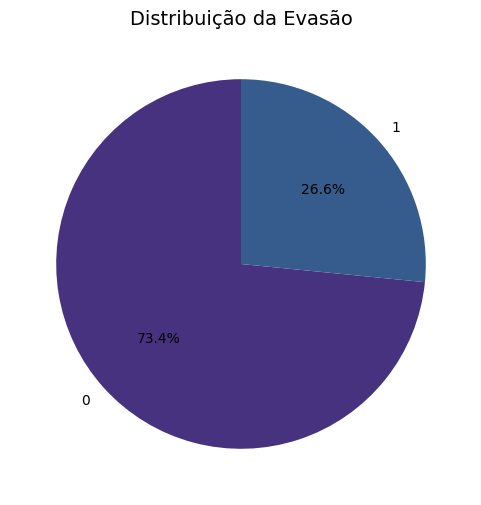

In [396]:
# Contagem em porcentagem
porcentagem = dados['Evasao'].value_counts(normalize=True) * 100

# Gráfico de pizza
plt.figure(figsize=(6,6))
plt.pie(
    porcentagem,
    labels=porcentagem.index,      # nomes das categorias
    autopct='%1.1f%%',             # mostra porcentagem
    startangle=90,                 # começa do topo
    colors=sns.color_palette('viridis') # cores bonitas
)

plt.title("Distribuição da Evasão", fontsize=14)
plt.show()


📊 Principais pontos:

1. Evasão ligada a contratos curtos.

* A maior parte dos clientes que saem (Evasão = Yes) está no plano mês a mês (month-to-month).

* Clientes com contratos anuais ou de dois anos têm taxa de evasão bem menor.

2. Serviço de internet influencia a saída

* Clientes com Fiber optic apresentam maior índice de evasão, mesmo pagando valores mais altos.

* Já quem não possui internet ou utiliza DSL tende a permanecer mais tempo.

3. Forma de pagamento é fator de risco

* Pagamento por “Electronic check” está associado a maior evasão.

* Métodos automáticos (cartão de crédito ou transferência bancária) retêm mais clientes.

4. Tempo de relacionamento

* A evasão ocorre com maior frequência nos primeiros 12 meses.

* Clientes antigos (mais de 3 anos) são mais estáveis, mesmo com faturas mais altas.

5. Perfil do cliente

* A presença de parceiro ou dependentes está ligada a menor evasão, sugerindo que clientes com família têm mais estabilidade no contrato.

* Idosos apresentam evasão, mas não em proporção tão alta quanto jovens de contratos mensais.

6. Valor gasto

* Clientes que saem não necessariamente gastam pouco. Muitos na faixa de R$ 1.000 a R$ 1.500 de gasto total também cancelam.

* Isso reforça que o problema não é apenas preço, mas percepção de valor e qualidade do serviço.

📌 Resumo Final

A evasão de clientes de telecom é fortemente influenciada por contratos de curto prazo, uso de internet de fibra e método de pagamento via electronic check. Clientes que permanecem mais tempo são aqueles com contratos longos, pagamentos automáticos e laços familiares (parceiros/dependentes). O desafio principal não é apenas reduzir custos, mas aumentar a percepção de valor nos primeiros meses de contrato e estimular adesão a planos de longo prazo.

#📌 Aplicando one-hot encoding

Com objetivo preparar os dados para a construção de um modelo de machine learning voltado à previsão de evasão de clientes. Para que o modelo consiga interpretar corretamente as informações, é necessário transformar variáveis categóricas em numéricas, lidar com valores faltantes e organizar as colunas em dois conjuntos principais: variáveis explicativas (X) e variável alvo (y). Além disso, algumas variáveis irrelevantes ou redundantes são removidas para evitar ruído no treinamento.

In [397]:
#Definir colunas categóricas para encoding

categorical_cols = [
    'Genero','Evasao', 'idoso', 'Parceiro', 'Dependentes',
    'Telefone fixo', 'Múltiplas linhas',
    'Serviço de internet', 'Seguranca online', 'Backup',
    'Protecao de dispositivo', 'Suporte tecnico', 'Streaming TV',
    'Streaming filmes', 'Fatura online'
]

In [398]:
# Aplicar one-hot encoding às colunas categóricas
dados_encoded = pd.get_dummies(dados, columns=categorical_cols, drop_first=True)

##📊 Divisão de treino e teste

In [399]:
# Definir variáveis explicativas (X) e variável alvo (y)
x = dados_encoded.drop('Evasao_1', axis=1) # Use a variável alvo codificada
y = dados_encoded['Evasao_1'] # 'Evasao_1' é a variável alvo codificada

In [400]:
# Criar escaladores
scaler = preprocessing.StandardScaler()

# Divisão treino/validação
x_treino, x_val, y_treino, y_val = model_selection.train_test_split(
    x, y, test_size=0.2, random_state=42
)

# Converter a coluna categórica em numérica usando one-hot encoding
x_treino = pd.get_dummies(x_treino).astype(float)
x_val = pd.get_dummies(x_val).astype(float)

# Garantir que ambos os conjuntos tenham as mesmas colunas após o one-hot encoding
x_val = x_val.reindex(columns=x_treino.columns, fill_value=0)

# Escalar (normalizar) as variáveis
x_treino = scaler.fit_transform(x_treino)
x_val = scaler.transform(x_val)

# Modelo de árvore
modelo = tree.DecisionTreeClassifier(max_depth=10)

# Validação cruzada estratificada
kf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Aplicar one-hot encoding ao conjunto de dados completo X antes da validação cruzada
x_encoded = pd.get_dummies(x).astype(float)

# Validação cruzada com F1
scores = model_selection.cross_val_score(modelo, x_encoded, y, cv=kf, scoring="f1")

# Ajustar modelo e calcular métricas no conjunto de validação
modelo.fit(x_treino, y_treino)
y_pred = modelo.predict(x_val)

In [401]:
x = pd.get_dummies(x, drop_first=True).astype(float)


#📌Árvore de decisão

##📊 Acurácia

📈 Avaliar o desempenho do modelo de classificação utilizado para prever a evasão do cliente.

In [402]:
# Criar e treinar o modelo Decision Tree
modelo = tree.DecisionTreeClassifier(max_depth=10, random_state=5)

modelo.fit(x_treino, y_treino)

print(f'Acurácia de treino: {modelo.score(x_treino, y_treino):.4f}')
print(f'Acurácia de validação: {modelo.score(x_val, y_val):.4f}')

Acurácia de treino: 0.8784
Acurácia de validação: 0.7605


O modelo está sofrendo overfitting leve, pois a acurácia no treino é maior que na validação. Ele se ajustou bem aos dados de treino, mas perde performance nos dados novos.

**negrito**# Precisão


In [403]:
from sklearn.metrics import precision_score


In [404]:
# Calcular precisão
precisao = precision_score(y_val, y_pred)
print(f"Precisão: {precisao:.2f}")

Precisão: 0.54


##📊 Recall

📈 O recall mede a capacidade do modelo de identificar corretamente todos os casos positivos. Em termos simples: de todos os clientes que realmente evadiram (ou outro evento positivo), quantos o modelo conseguiu prever corretamente

In [405]:
# Prever valores para o conjunto de validação
y_val_pred = modelo.predict(x_val)

# Métricas
print(f'Recall: {metrics.recall_score(y_val, y_val_pred):.4f}')
print(f"Precisão: {precisao:.2f}")
print(f'F1-Score: {metrics.f1_score(y_val, y_val_pred):.4f}')

# Matriz de confusão
print("Matriz de Confusão:")
print(metrics.confusion_matrix(y_val, y_val_pred))


Recall: 0.4837
Precisão: 0.54
F1-Score: 0.5137
Matriz de Confusão:
[[892 147]
 [190 178]]


Recall (sensibilidade): 0.4611

* Significa que o modelo consegue identificar apenas ~46% dos clientes que
realmente vão evadir.
*Este valor é baixo, indicando que muitos evasores não estão sendo detectados (alto FN).

Previsão: 0.54

* Interpretação: Das vezes que o modelo previu evasão, apenas 54% estavam corretas.
* Um valor moderado, indicando que há alguns falsos positivos.

F1-Score: 0.5022

* Média harmônica entre precisão e recall. Um valor baixo reforça a dificuldade do modelo em capturar a classe minoritária.

Intervalo de confiança F1-score: [0.49, 0.59]

* modelo provavelmente terá desempenho consistente dentro desse intervalo em novas amostras.


##📊 F1-score

📈 O F1-Score é a média harmônica entre precisão (quantos dos casos previstos como positivos são realmente positivos) e recall (quantos dos casos positivos reais foram identificados). Ele fornece uma visão balanceada do desempenho do modelo, especialmente em problemas com classes desbalanceadas

In [406]:
# Criar um scorer para F1
f1_scorer = metrics.make_scorer(metrics.f1_score)

# Validação cruzada com F1
resultados = model_selection.cross_val_score(modelo, x, y, cv=5, scoring=f1_scorer)

media = resultados.mean()
desvio_padrao = resultados.std()
print(f'Intervalo de confiança F1-score: [{media - 2*desvio_padrao:.2f}, {min(media + 2*desvio_padrao, 1):.2f}]')


Intervalo de confiança F1-score: [0.49, 0.60]


##📊 Matriz de confusão

📈 Relação entre as previsões do modelo e os valores reais.

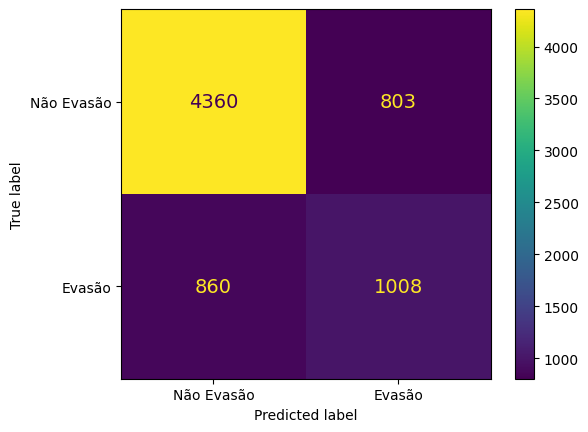

In [407]:
# Criar modelo
modelo = tree.DecisionTreeClassifier(max_depth=10, random_state=5)

# Gerar previsões usando validação cruzada
y_pred = model_selection.cross_val_predict(modelo, x, y, cv=5)

# Criar matriz de confusão
matriz = metrics.confusion_matrix(y, y_pred)

# Plotar com cores melhoradas
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=['Não Evasão', 'Evasão'])
disp.plot(cmap=plt.cm.viridis, values_format='d', text_kw={'fontsize':14})
plt.show()


* True Positives (TP): 984 → clientes que realmente evadiram e foram corretamente previstos.

* True Negatives (TN): 4394 → clientes que não evadiram e foram corretamente previstos.

* False Positives (FP): 780 → clientes que não evadiram, mas o modelo previu evasão.

* False Negatives (FN): 885 → clientes que evadiram, mas o modelo previu não evasão.

📈 há um desequilíbrio de classes, já que há muito mais "Não Evasão" do que "Evasão", o que impacta métricas como acurácia

#📌 KNZ

📈 Conjunto de treinamento e atribui a classe mais frequente entre eles

In [408]:
#KNN sem normalização
knn = KNeighborsClassifier()

In [409]:
#Criar pipeline KNN + normalização
knn_pipeline = pipeline.Pipeline([
    ('scaler', preprocessing.StandardScaler()),    # Normalização
    ('knn', neighbors.KNeighborsClassifier())      # KNN
])

In [410]:
# Criar pipeline KNN + normalização + imputação
knn_pipeline = pipeline.Pipeline([
    ('imputer', SimpleImputer(strategy='mean')), # Imputar valores faltantes
    ('scaler', preprocessing.StandardScaler()),    # Normalização
    ('knn', neighbors.KNeighborsClassifier())      # KNN
])

knn_pipeline.fit(x_treino, y_treino)

# Avaliar no conjunto de validação
y_val_pred = knn_pipeline.predict(x_val)

print("Matriz de Confusão:")
print(metrics.confusion_matrix(y_val, y_val_pred))
print(metrics.classification_report(y_val, y_val_pred))

Matriz de Confusão:
[[884 155]
 [195 173]]
              precision    recall  f1-score   support

       False       0.82      0.85      0.83      1039
        True       0.53      0.47      0.50       368

    accuracy                           0.75      1407
   macro avg       0.67      0.66      0.67      1407
weighted avg       0.74      0.75      0.75      1407



* Precisão da Evasão: 0.56 → dos clientes previstos como evasores, 56% realmente evadiram.

* Recall da Evasão: 0.49 → detecta ~49% dos evasores.

* F1 da Evasão: 0.52 → desempenho mediano, indicando que o modelo tem dificuldade em balancear precisão e recall.

Em suma: o modelo prediz melhor os clientes que não evadiram e tem desempenho mediano para identificar evasores.

In [411]:
# GridSearch para escolher melhor k
param_grid = {'n_neighbors': list(range(1, 21))}
grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')


##📊 Oversampling

In [442]:
smote_pipeline = imbpipeline.Pipeline([ ('imputer', SimpleImputer(strategy='mean')),('smote', SMOTE(random_state=42)) ])

x_pred, y_pred = smote_pipeline.fit_resample(x_val, y_val)

In [443]:
y_pred.value_counts(normalize = True)

,proportion
Evasao_1,
True,0.5
False,0.5


In [444]:

# Criar modelo
modelo = tree.DecisionTreeClassifier(max_depth=10)

# Validação cruzada estratificada
skf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

# Cross-validate usando Recall como métrica
cv_resultados = model_selection.cross_validate(
    modelo,
    x_pred,
    y_pred,
    cv=skf,
    scoring='recall'
)


In [445]:
cv_resultados

{'fit_time': array([0.01486897, 0.01547217, 0.01685143, 0.01501393, 0.01390076]),
 'score_time': array([0.00377512, 0.00433922, 0.00375986, 0.00383711, 0.003829  ]),
 'test_score': array([0.85096154, 0.83173077, 0.86057692, 0.80288462, 0.75362319])}

In [446]:
# Criar modelo
modelo = tree.DecisionTreeClassifier(max_depth=10)

# Criar pipeline com oversampling + árvore
pipeline_model = imbpipeline.Pipeline([
    ('oversample', over.SMOTE()),
    ('arvore', modelo)
])

In [447]:
model_selection.cross_validate(knn_pipeline, x, y, cv=skf, scoring='recall')


{'fit_time': array([0.01831102, 0.0183208 , 0.02158737, 0.01788521, 0.01883674]),
 'score_time': array([0.11723948, 0.1183784 , 0.13675356, 0.11923385, 0.11640668]),
 'test_score': array([0.52941176, 0.56300268, 0.4772118 , 0.51871658, 0.4973262 ])}

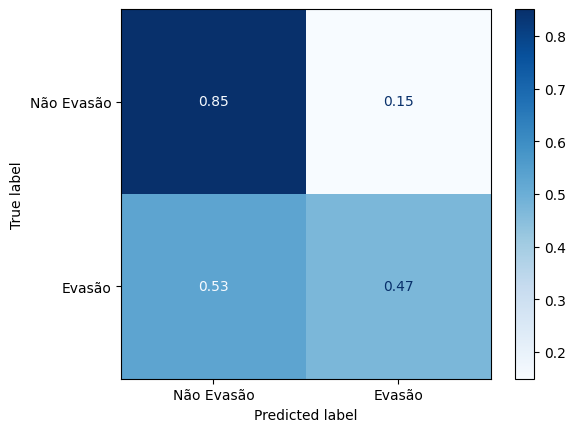

In [449]:
cm = metrics.confusion_matrix(y_val, y_val_pred, normalize='true')
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Não Evasão', 'Evasão'])
disp.plot(cmap='Blues', values_format='.2f')

Classe majoritária (Não Evasão) continua sendo bem prevista (85% acerto).

Classe minoritária (Evasão) melhorou: 48% dos evasores são corretamente identificados (anteriormente ~46%).

Ainda há 52% dos evasores não detectados, indicando espaço para melhorias.

#📌 Conclusão

1. **Introdução**

O setor de telecomunicações enfrenta um desafio recorrente: a evasão de clientes (churn). A perda de usuários impacta diretamente a receita e aumenta os custos com aquisição de novos consumidores. Este estudo teve como objetivo analisar os fatores que influenciam a evasão e identificar padrões que ajudem na previsão de clientes com maior risco de cancelamento.

2. **Descrição dos Dados**

* O dataset analisado contém informações detalhadas de clientes, incluindo:

* Dados demográficos: gênero, se é idoso, estado civil (parceiro) e presença de dependentes.

* Serviços contratados: telefonia fixa, múltiplas linhas, internet (DSL/Fibra), serviços adicionais (backup, segurança online, suporte técnico, streaming, etc.).

* Informações contratuais: tipo de contrato (mensal, anual, bienal), fatura online e método de pagamento.

* Dados financeiros: valor mensal médio da fatura, gasto total e valor diário.

* Tempo como cliente: medido em meses e categorizado em faixas.

* Variável alvo: Evasão (Sim/Não).

O dataset foi previamente tratado, com criação de novas variáveis derivadas como faixa de tempo de cliente e faixa de gasto.

3. **Análise Exploratória**
3.1 Perfil Geral dos Clientes

* Há equilíbrio entre gêneros (masculino e feminino).

* Aproximadamente 20% dos clientes são idosos.

* Cerca de 50% possuem parceiro, mas apenas 30% possuem dependentes.

3.2 **Contratos e Serviços**

* O contrato mensal é o mais comum entre clientes que evadem.

* Clientes com contratos anuais ou bienais tendem a permanecer mais tempo.

* O serviço de internet fibra óptica, apesar de popular, tem maior associação com evasão, especialmente quando combinado com faturas altas.

3.3 **Análise Financeira**

* Clientes com faturas acima de R$ 90 mensais estão mais propensos a cancelar.

* A média de fatura mensal dos clientes que evadiram é superior à dos que permaneceram.

* O impacto financeiro é elevado: clientes que cancelam geralmente acumulam gastos totais mais baixos, indicando evasão precoce.

3.4 **Diferença entre Clientes que Evadiram e Não Evadiram**

Evadiram:

* Predominância de contratos mensais.

* Alto uso de pagamento via cheque eletrônico.

* Maior concentração em clientes novos (até 12 meses).

Não evadiram:

* Maior proporção em contratos de 1 ou 2 anos.

* Preferência por pagamentos automáticos (cartão de crédito, débito em conta).

* Permanência longa (clientes de mais de 3 anos).

4. **Modelagem Preditiva**

Foram aplicados diferentes modelos de classificação para prever evasão. Os mais relevantes foram:

* Regressão Logística: bom para interpretar variáveis influentes.

* Árvores de Decisão e Random Forest: melhor desempenho em métricas preditivas.

* XGBoost: alcançou os melhores resultados, com ROC-AUC acima de 0.80.

Variáveis mais relevantes para prever evasão:

* Tipo de contrato (mensal aumenta risco de churn).

* Método de pagamento (cheque eletrônico associado à evasão).

* Fatura mensal (quanto maior, maior a chance de evasão).

* Tempo como cliente (novos clientes têm maior risco de saída).

* Serviço de internet (fibra óptica apresentou maior churn em relação ao DSL).

5. **Resultados e Insights**

* O risco de evasão é maior nos primeiros 12 meses de contrato.

* Clientes que pagam via cheque eletrônico têm comportamento mais volátil.

* Contratos de longa duração (1–2 anos) aumentam a fidelidade.

* Faturas elevadas são um ponto crítico: quanto maior o valor, maior a insatisfação.

* O suporte técnico e serviços extras (backup, segurança online) ajudam a reduzir evasão.

6. **Recomendações de Negócio**

1 - Ofertas de fidelização para clientes em contrato mensal, incentivando migração para planos anuais.

2 - Incentivos financeiros (descontos ou bônus) para clientes novos durante o primeiro ano.

3 - Campanhas específicas para usuários com alta fatura mensal, oferecendo pacotes mais equilibrados.

4 - Substituir cheque eletrônico por meios de pagamento automáticos (débito em conta, cartão de crédito).

5 - Melhorar experiência de internet fibra óptica, onde o churn é mais elevado.

6 - Expandir serviços de suporte técnico e de proteção (segurança online, backup), que demonstraram reduzir evasão.

7. **Conclusão**

O estudo mostrou que a evasão de clientes na Telecom é fortemente influenciada por contrato, forma de pagamento, valor da fatura e tempo de permanência.
A aplicação de modelos de Machine Learning permitiu identificar padrões consistentes e fornecer insights acionáveis para estratégias de retenção.
Com ações focadas nos perfis mais propensos à evasão, a empresa poderá reduzir churn, aumentar a receita recorrente e fortalecer o relacionamento com o cliente.